# Step 1_Movie Features Clustering
**Note**: This part of codes include 3 parts:
* Part I: Features Clustering using K-means  
This part shows the final result of movie features clustering.
* Part II: Analysis the characteritics of each cluster  
This part shows the visualization of the clusters' features. Through the visualization, we can conclude the characteristics of each cluster.
* Part III: Features Clustering using Hierarchical clustering  
This part shows the Hierarchical clustering method that we have tried to conduct the clustering.

**Data Required**:
imdb_clustering.csv, merge.csv, movies_features_clusters.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import cluster
import scipy.cluster.hierarchy as hcluster
from sklearn import preprocessing

# Part I: Features Clustering (K-means)

## 1.1 Data cleaning

In [2]:
# Read csv
movie_features = pd.read_csv("imdb_clustering.csv", index_col= None)

In [3]:
# drop na in 'running_time'
movie_features = movie_features[movie_features.running_time.notnull()]

# drop non-numerical data
movie_features = movie_features.drop(['company','distributor'], axis = 1)

### fill the na in `budget`

In [4]:
## find the variables corrlated with budget (cor>0.2)
budget_cor = abs(movie_features.corr(method='pearson')['budget']).sort_values(ascending = False)
predict_df = movie_features[budget_cor[budget_cor>0.2].index]

## train a random forest model to predict the nan value
y_train = predict_df[predict_df.budget.notnull()]['budget']
y_test = predict_df[predict_df.budget.isnull()]['budget']
x_train = predict_df[predict_df.budget.notnull()].drop(['budget'], axis=1)
x_test = predict_df[predict_df.budget.isnull()].drop(['budget'], axis=1)

fiil_rfc = RandomForestRegressor(n_estimators=100)
fiil_rfc = fiil_rfc.fit(x_train, y_train)
predict_budget = fiil_rfc.predict(x_test)

## fill the predicted budget in the data
fill_index = movie_features[movie_features['budget'].isnull().values==True].index
for i in range(len(predict_budget)):
    movie_features.budget[fill_index[i]] = predict_budget[i]

/var/folders/tm/tm3nbsg90_v7ks0h366p9c080000gn/T/ipykernel_5118/3836575696.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_features.budget[fill_index[i]] = predict_budget[i]


In [5]:
# drop the relevant variables after the release of the movies and the variables with repeated meanings
movie_features = movie_features.drop(['release_endtime','gross_us','opening_wkd','awards',
                                      'release_starttime'], axis = 1)

In [6]:
# check whether there is na now
movie_features[movie_features.isnull().values==True]

,imdb_id,mpaa_rating,running_time,budget,genres_Action,genres_Adventure,genres_Animation,genres_Biography,genres_Comedy,genres_Crime,...,country_United Kingdom,country_France,country_Canada,country_India,country_other,language_English,language_French,language_Hindi,language_other,show_time_week


## 1.2 Kmeans clustering

### find the optimal cluster number `k`

Text(0, 0.5, 'WCSS')

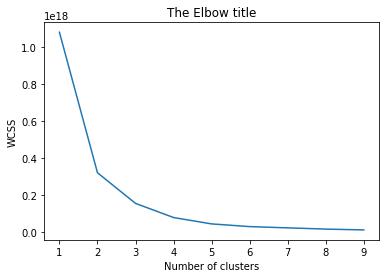

In [7]:
# wcss = within-cluster sum of squares (i.e. variance)
wcss = []
for i in range(1,10):
    kmeans = KMeans(i)
    kmeans.fit(movie_features.iloc[:,1:])
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,10)
plt.plot(number_clusters, wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# choose k = 3

### clustering and combine with the orgianl data

In [8]:
# data Normalization
ms = MinMaxScaler()
cluster_data = ms.fit_transform(movie_features.iloc[:,1:])
cols = movie_features.iloc[:,1:].columns
cluster_data = pd.DataFrame(cluster_data, columns=[cols])
#cluster_data.head()

# clustering via KMeans
km = KMeans(n_clusters = 3, random_state = 0)
clusters = km.fit_predict(cluster_data)

# Add the cluster column
movies_data = pd.read_csv("merge.csv", index_col = None)
clusters_data = movie_features[['imdb_id']]
movie_features['feature_clusters'] = clusters
clusters_data['feature_clusters'] = clusters
movies_with_clusters = pd.merge(movies_data, clusters_data,on = 'imdb_id',how = 'inner')

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/var/folders/tm/tm3nbsg90_v7ks0h366p9c080000gn/T/ipykernel_5118/1352964900.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clusters_data['feature_clusters'] = clusters


In [9]:
# save as csv
movies_with_clusters.to_csv("movies_with_clusters.csv", index = False)
movie_features.to_csv("movies_features_clusters.csv", index = False)

# Part II: Analysis the characteritics of each cluster

### Cluster 0
* **Total Movies**: 49
* **Budget**: highest, mean = 7.502269e+07
* **Running Time**: median, mean = 105.653061
* **Show Time**: shortest, mean = 10.428571
* **Mpaa Rating**: 1&2 (not including 5) -> under 13&17 years old 
* **Genres**: Action, Crime, Horror, Mystery, Sci-Fi, Thriller
* **Country**(besides USA): mainly includes France, Canada
* **Language**(besides English): mainly includes other languages

### Cluster 1
* **Total Movies**: 78
* **Budget**: median, mean = 6.026443e+07
* **Running Time**: shortest, mean = 103.294872
* **Show Time**: median, mean = 13.564103
* **Mpaa Rating**: 1,2,3&4 (not including 5, mpaa rating 2,3,4 is more than the other 2 clusters)
* **Genres**: Comedy, Family, Romance
* **Country**(besides USA): mainly includes India
* **Language**(besides English): mainly includes Hindi

### Cluster 2
* **total movies**: 73
* **Budget**: lowest, mean = 4.115931e+07
* **Running Time**: longest, mean = 112.726027
* **Show Time**: longest, mean = 14.890411
* **Mpaa Rating**: all (mpaa rating 1 is more than the other 2 clusters)
* **Genres**: Adventure, Biography, Drama, Documentary, Fantasy, History, Music
* **Country**(besides USA): mainly includes United Kingdom and other countries
* **Language**(besides English): mainly includes French


In [10]:
movie_features = pd.read_csv("movies_features_clusters.csv", index_col= None)

### count the number of movies in each cluster

In [11]:
movie_features.groupby(['feature_clusters'],group_keys = True)['imdb_id'].count().reset_index()

,feature_clusters,imdb_id
0,0,49
1,1,78
2,2,73


### `running_time` & `budget` & `show_time_week` -- boxplot

* `running time`: mean (cluster 2 > cluster 1 >≈ cluster 0)   
* `budget`: mean (cluster 2 < cluster 1 < cluster 0)  
* `show time week`: mean (cluster 2 > cluster 1 > cluster 0) -> Not much difference 

**Conclusion**

* cluster 0: highest budget, lowest show time and running time
* cluster 1: median budget, show time and running time
* cluster 2: lowest budget, longest show time and running time

In [12]:
movie_features.groupby(['feature_clusters'],group_keys = True)['budget'].mean().reset_index()

,feature_clusters,budget
0,0,7.460176e+07
1,1,5.990164e+07
2,2,4.115345e+07


In [13]:
movie_features.groupby(['feature_clusters'],group_keys = True)['running_time'].mean().reset_index()

,feature_clusters,running_time
0,0,105.653061
1,1,103.294872
2,2,112.726027


In [14]:
movie_features.groupby(['feature_clusters'],group_keys = True)['show_time_week'].mean().reset_index()

,feature_clusters,show_time_week
0,0,10.428571
1,1,13.564103
2,2,14.890411


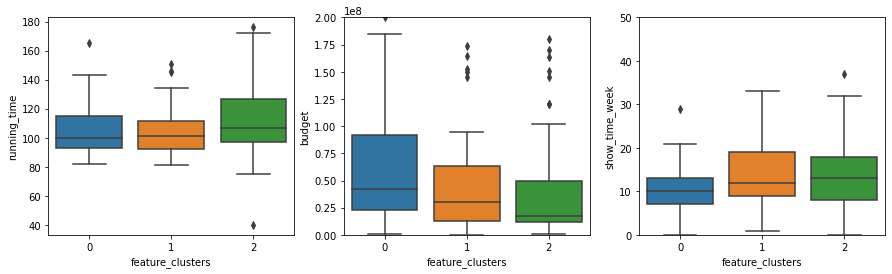

In [15]:
# 'running_time' & 'budget' & 'show_time_week'
fig, ax = plt.subplots(1,3, figsize=(15,4))
ax1 = sns.boxplot(x = 'feature_clusters', y = 'running_time', data = movie_features, ax=ax[0])
ax2 = sns.boxplot(x = 'feature_clusters', y = 'budget', data = movie_features, ax=ax[1])
ax2.set(ylim = (0, 2e8))
ax3 = sns.boxplot(x = 'feature_clusters', y = 'show_time_week', data = movie_features, ax=ax[2])
ax3.set(ylim = (0, 50))
plt.show()

### `mpaa_rating` -- using countplot

**Conclusion**

* cluster 0: mainly mpaa rating 1&2 (not including 5) -> under 13&17 years old   
* cluster 1: mainly mpaa rating 1,2,3&4 (not including 5, mpaa rating 2,3,4 is more than the other 2 clsuters) 
* cluster 2: all (mpaa rating 1 is more than the other 2 clsuters)

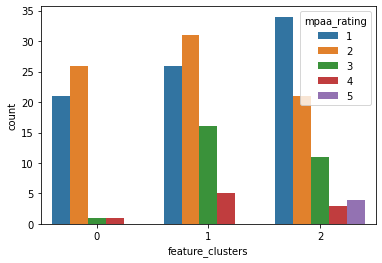

In [16]:
# 'mpaa_rating'
ax = sns.countplot(x = 'feature_clusters', hue = 'mpaa_rating', data = movie_features)

### `genres` variables -- using countplot

* `genres_Action`: cluster 0 > cluster 1 ≈ 0
* `genres_Adventure`: cluster 2 > cluster 0 > cluster 1  
* `genres_Biography`: cluster 2 > cluster 1 ≈ 0 
* `genres_Comedy`: cluster 1
* `genres_Crime`: cluster 0 > cluster 1 > cluster 2
* `genres_Drama`: cluster 2 > cluster 1 > cluster 0 ≈ 0  
* `genres_Documentary`: cluster 2 > cluster 1 ≈ 0 
* `genres_Fantasy`: cluster 2 > cluster 0 > cluster 1  
* `genres_Family`: cluster 1 > cluster 2
* `genres_History`: cluster 2
* `genres_Horror`: cluster 0 > cluster 1 ≈ cluster 2 ≈ 0
* `genres_Mystery`: cluster 0 > cluster 2 
* `genres_Musical`: cluster 1 ≈ cluster 2 ≈ 0
* `genres_Music`: cluster 2 > cluster 1 
* `genres_Romance`: cluster 1 > cluster 2 > cluster 0 ≈ 0
* `genres_Sci-Fi`: cluster 0 > cluster 2 > cluster 1
* `genres_Sport`: cluster 1 ≈ cluster 2  ≈ 0
* `genres_Thriller`: cluster 0 > cluster 2 
* `genres_War`: cluster 0 ≈ cluster 2 ≈ 0
* `genres_Western`: cluster 1 ≈ cluster 2 ≈ 0

**Conclusion**

* cluster 0: Action, Crime, Horror, Mystery, Sci-Fi, Thriller
* cluster 1: Comedy, Family, Romance
* cluster 2: Adventure, Biography, Drama, Documentary, Fantasy, History, Music

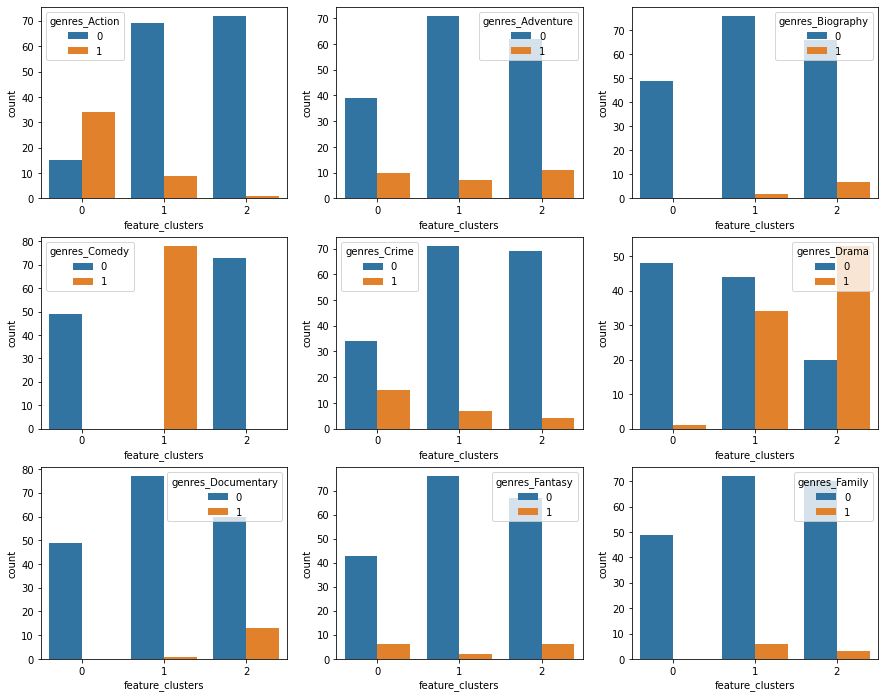

In [17]:
# 'genres_Action', 'genres_Adventure', 'genres_Biography',
# 'genres_Comedy', 'genres_Crime', 'genres_Drama',
# 'genres_Documentary', 'genres_Fantasy', 'genres_Family'
fig, ax = plt.subplots(3,3, figsize=(15,12))
ax1 = sns.countplot(x = 'feature_clusters', hue = 'genres_Action', data = movie_features, ax=ax[0,0])
ax2 = sns.countplot(x = 'feature_clusters', hue = 'genres_Adventure', data = movie_features, ax=ax[0,1])
ax3 = sns.countplot(x = 'feature_clusters', hue = 'genres_Biography', data = movie_features, ax=ax[0,2])
ax4 = sns.countplot(x = 'feature_clusters', hue = 'genres_Comedy', data = movie_features, ax=ax[1,0])
ax5 = sns.countplot(x = 'feature_clusters', hue = 'genres_Crime', data = movie_features, ax=ax[1,1])
ax6 = sns.countplot(x = 'feature_clusters', hue = 'genres_Drama', data = movie_features, ax=ax[1,2])
ax7 = sns.countplot(x = 'feature_clusters', hue = 'genres_Documentary', data = movie_features, ax=ax[2,0])
ax8 = sns.countplot(x = 'feature_clusters', hue = 'genres_Fantasy', data = movie_features, ax=ax[2,1])
ax9 = sns.countplot(x = 'feature_clusters', hue = 'genres_Family', data = movie_features, ax=ax[2,2])
plt.show()

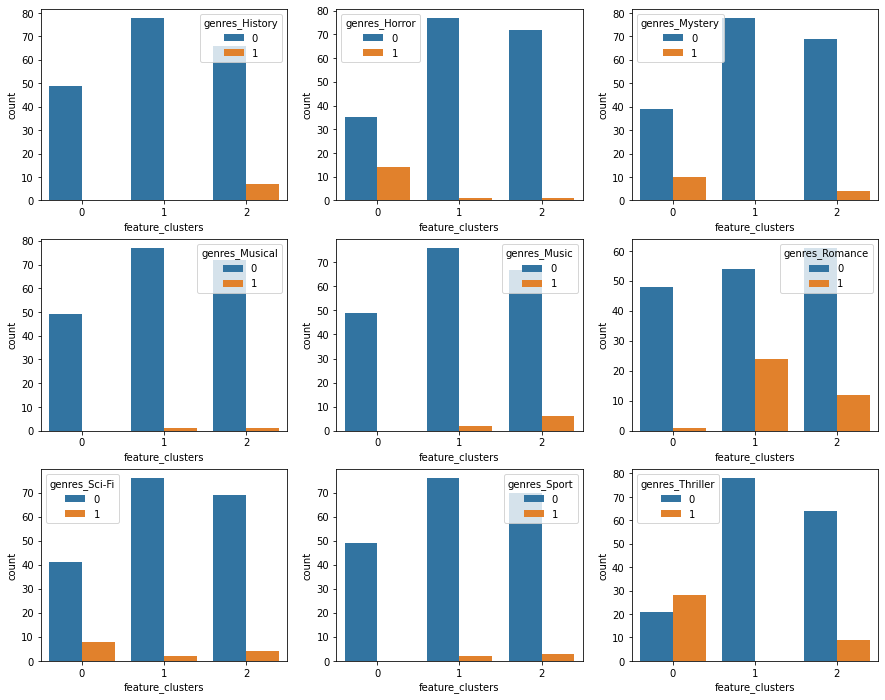

In [18]:
# 'genres_History','genres_Horror', 'genres_Mystery', 
# 'genres_Musical', 'genres_Music', 'genres_Romance',
# 'genres_Sci-Fi', 'genres_Sport', 'genres_Thriller'

fig, ax = plt.subplots(3,3, figsize=(15,12))
ax1 = sns.countplot(x = 'feature_clusters', hue = 'genres_History', data = movie_features, ax=ax[0,0])
ax2 = sns.countplot(x = 'feature_clusters', hue = 'genres_Horror', data = movie_features, ax=ax[0,1])
ax3 = sns.countplot(x = 'feature_clusters', hue = 'genres_Mystery', data = movie_features, ax=ax[0,2])
ax4 = sns.countplot(x = 'feature_clusters', hue = 'genres_Musical', data = movie_features, ax=ax[1,0])
ax5 = sns.countplot(x = 'feature_clusters', hue = 'genres_Music', data = movie_features, ax=ax[1,1])
ax6 = sns.countplot(x = 'feature_clusters', hue = 'genres_Romance', data = movie_features, ax=ax[1,2])
ax7 = sns.countplot(x = 'feature_clusters', hue = 'genres_Sci-Fi', data = movie_features, ax=ax[2,0])
ax8 = sns.countplot(x = 'feature_clusters', hue = 'genres_Sport', data = movie_features, ax=ax[2,1])
ax9 = sns.countplot(x = 'feature_clusters', hue = 'genres_Thriller', data = movie_features, ax=ax[2,2])
plt.show()

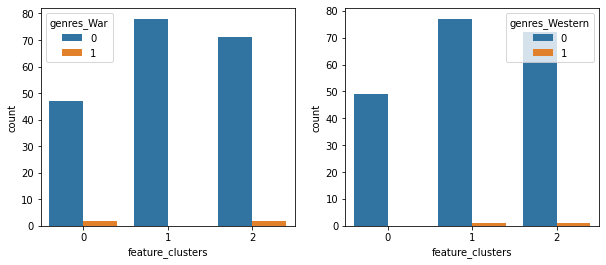

In [19]:
# 'genres_War', 'genres_Western'

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax1 = sns.countplot(x = 'feature_clusters', hue = 'genres_War', data = movie_features, ax=ax[0])
ax2 = sns.countplot(x = 'feature_clusters', hue = 'genres_Western', data = movie_features, ax=ax[1])
plt.show()

### `country` variables -- using countplot

* `United States`: cluster 1 > cluster 2 > cluster 0 > 40
* `United Kingdom`: 15 > cluster 2 > cluster 1 > cluster 0  
* `France`: 10 > cluster 0 > cluster 2 > cluster 1
* `Canada`: cluster 0 ≈ cluster 1 > cluster 2 ≈ 0
* `India`: cluster 1 > cluster 1 ≈ cluster 2 ≈ 0
* `other`: cluster 2 > cluster 0 > cluster 1 > 10  

**Conclusion**  
Besides United States,
* cluster 0: mainly includes France, Canada
* cluster 1: mainly includes India
* cluster 2: mainly includes United Kingdom and other countries

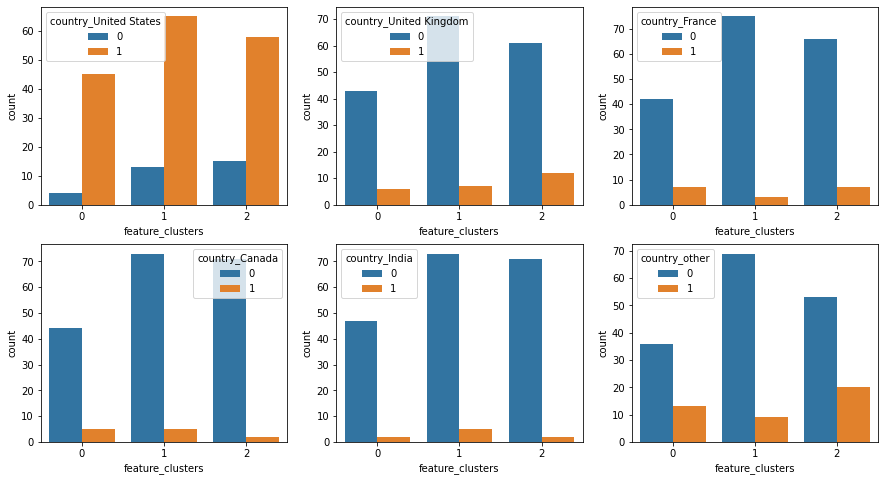

In [20]:
# 'country_United States', 'country_United Kingdom', 'country_France', 
# 'country_Canada', 'country_India', 'country_other'

fig, ax = plt.subplots(2,3, figsize=(15,8))
ax1 = sns.countplot(x = 'feature_clusters', hue = 'country_United States', data = movie_features, ax=ax[0,0])
ax2 = sns.countplot(x = 'feature_clusters', hue = 'country_United Kingdom', data = movie_features, ax=ax[0,1])
ax3 = sns.countplot(x = 'feature_clusters', hue = 'country_France', data = movie_features, ax=ax[0,2])
ax4 = sns.countplot(x = 'feature_clusters', hue = 'country_Canada', data = movie_features, ax=ax[1,0])
ax5 = sns.countplot(x = 'feature_clusters', hue = 'country_India', data = movie_features, ax=ax[1,1])
ax6 = sns.countplot(x = 'feature_clusters', hue = 'country_other', data = movie_features, ax=ax[1,2])
plt.show()

### `language`  variables -- using countplot

* `English`: cluster 1 > cluster 2 > cluster 0 > 40
* `French`: 15 > cluster 2 > cluster 1 > cluster 0 ≈ 0
* `Hindi`: 10 > cluster 1 > cluster 2 > cluster 0 ≈ 0
* `other`: cluster 0 > cluster 1 > cluster 2 > 10

**Conclusion**  
Besides English,
* cluster 0: mainly includes other languages
* cluster 1: mainly includes Hindi
* cluster 2: mainly includes French

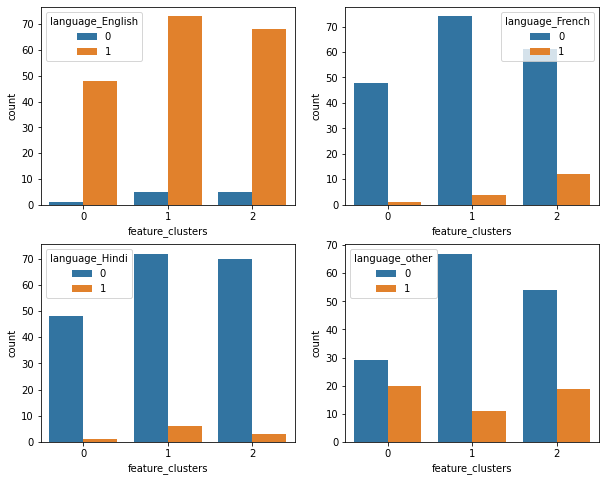

In [21]:
# 'language_English', 'language_French', 'language_Hindi', 'language_other',

fig, ax = plt.subplots(2,2, figsize=(10,8))
ax1 = sns.countplot(x = 'feature_clusters', hue = 'language_English', data = movie_features, ax=ax[0,0])
ax2 = sns.countplot(x = 'feature_clusters', hue = 'language_French', data = movie_features, ax=ax[0,1])
ax3 = sns.countplot(x = 'feature_clusters', hue = 'language_Hindi', data = movie_features, ax=ax[1,0])
ax4 = sns.countplot(x = 'feature_clusters', hue = 'language_other', data = movie_features, ax=ax[1,1])
plt.show()

# Part III: Features Clustering using Hierarchical clustering

In [22]:
movie_features = pd.read_csv("movies_features_clusters.csv", index_col= None)

In [23]:
movie_features = movie_features.drop(['feature_clusters'], axis=1)
scaler = MinMaxScaler()
scaler = scaler.fit(movie_features.iloc[:,1:])
X_scaled_MM = scaler.transform(movie_features.iloc[:,1:])

For the `method` parameter, we tried 6 methods: 'centroid', 'single', 'complete', 'weighted', 'median','ward'.  
Here only shows one of the methods that perfrom a little better result.

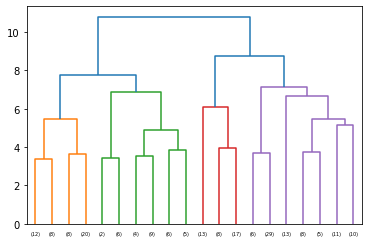

In [24]:
scaled_MM = hcluster.linkage(X_scaled_MM, method='ward')

hcluster.dendrogram(scaled_MM, truncate_mode='lastp', p=20, leaf_font_size=5.)

scaled_MM_p = hcluster.fcluster(scaled_MM, 4., criterion='maxclust')